# Duolingo's AI Stance: A Sentiment Analysis of Reddit's Response

Companies often face tough decisions, and understanding audience reactions during these pivotal moments is crucial. **Sentiment analysis**, a powerful Natural Language Processing (NLP) technique, provides computational methods to uncover the emotional tone of text, revealing public perception at scale.

One company I’ve followed closely over the years is **Duolingo** — partly because of my own 1,775-day streak (and counting!), but also because of the brand’s creative and bold marketing strategies. Despite its viral success and strong user base, Duolingo recently experienced one of its most controversial moments: on **April 28, 2025**, CEO Luis von Ahn announced that the company would become "AI-first," sparking widespread backlash across social media. Longtime users expressed disappointment, with some reporting account deletions and subscription cancellations.

Just weeks later, Duolingo adjusted its initial stance. On **May 23, 2025**, von Ahn clarified that AI would not replace employees but rather support them, signaling a shift in messaging and strategy.

In this project, I analyze Reddit posts and comments around these events to answer key questions:
- How did public emotions evolve before and after the AI announcement?
- What were the dominant sentiments during each phase?
- Did the clarification message help shift the narrative?

Using tools like **PRAW** for data collection, **Hugging Face's emotion classification pipeline**, and visualization libraries such as **Seaborn** and **Matplotlib**, I explore how NLP can help companies understand audience sentiment during moments of crisis — and what happens when they respond.

Let’s dive into the data and see what Reddit had to say.

---

## 1. Data Collection

### 1.1. Platform and Date Range Choice

To assess public sentiment regarding Duolingo's corporate decision, **Reddit** was selected as the primary data source due to its diverse, topic-driven communities and publicly accessible API. **Reddit API** was used in conjunction with Python tools like **PRAW** (Python Reddit API Wrapper) to automate and structure the data collection process. 

To establish a baseline and capture immediate public reactions, I collected data for specific periods around Duolingo's AI announcement:

* **Pre-Decision Period:** Three months prior to the company's AI decision. This extended timeframe provides a comprehensive view of pre-event sentiment, helping to differentiate event-driven shifts from existing trends.

* **Post-Decision Period:** One month following the company's AI announcement. This period captures the direct aftermath and public response.

### 1.2. Data Acquisition

The data collection was performed using a Python script, with the **PRAW** library to interact with the Reddit API. The script was designed to:

* **Authenticate** securely using API credentials stored in a local `config.ini` file, ensuring sensitive information remains separate from the main codebase.

* **Target specific subreddits** curated for their relevance to corporate news, technology, business, and company-specific discussions.

* **Construct a precise search query** combining the company name with the keywords "AI" and "AI-first" to ensure the relevance of retrieved content.

* **Fetch both submissions (posts) and their top-level comments**, recognizing that comments often contain rich, direct expressions of sentiment.

* **Filter content by date** to align with the defined pre- and post-decision periods, ensuring only relevant historical data is included.

* **Manage API rate limits** with built-in time delays, ensuring respectful and consistent data retrieval from Reddit's servers.

* **Store the collected data** in a structured Pandas DataFrame for analysis, and export to a CSV for reproducibility and persistent storage.

Let's begin by importing the necessary libraries and gathering the data.

In [1]:
# Reddit API & Data Handling
import praw
import configparser
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import warnings

# Text Processing & NLP
import re
import emoji
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
import torch

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from PIL import Image, ImageOps, ImageFilter, ImageDraw
from tqdm.notebook import tqdm

In [2]:
# --- PRAW Configuration ---
# Read Reddit API credentials from 'config.ini' in the project root
config = configparser.ConfigParser()
config_file_path = '../config.ini'

if not os.path.exists(config_file_path):
    raise FileNotFoundError(f'❌ Configuration file \'{config_file_path}\' not found. Ensure it\'s in the project root.')

try:
    config.read(config_file_path)
    client_id = config['reddit']['client_id']
    client_secret = config['reddit']['client_secret']
    username = config['reddit']['username']
    password = config['reddit']['password']
except KeyError as e:
    raise KeyError(f'❌ Missing key in \'{config_file_path}\' under [reddit] section: {e}')

# User agent for PRAW
user_agent = 'MyDataSciencePortfolioProject/1.0 (by /u/Matt_RC21)'

reddit = None
try:
    reddit = praw.Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent,
        username=username,
        password=password
    )
    print('✅ PRAW initialized successfully.')
except Exception as e:
    raise ConnectionError(f'❌ Failed to initialize PRAW. Check credentials: {e}')

# --- Project Parameters ---
# Duolingo AI-first announcement date
decision_date = datetime.strptime('2025-04-28', '%Y-%m-%d')

# Target subreddits for relevant discussions
target_subreddits = [
    'duolingo', 'languagelearning', 'artificial', 'ArtificialInteligence', 'technology',
    'Futurology', 'jobs', 'programming', 'business'
]

# Search query for Reddit content
duolingo_ai_query = '(\'Duo\' OR \'Duolingo\') AND (\'AI\' OR \'AI-first\')'

# --- Reddit Data Collection Function ---
def collect_reddit_data(start_date, end_date, reddit_instance, subreddits_list, query_terms, limit=1000):
    """Collects Reddit posts and top-level comments for a topic within a date range."""
    collected_data = []
    
    print(f'Collecting data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}.')
    
    for subreddit_name in subreddits_list:
        try:
            subreddit = reddit_instance.subreddit(subreddit_name)
            
            # Search submissions; filter by date after fetching due to PRAW's coarse time_filter
            for submission in subreddit.search(query_terms, sort='relevance', time_filter='all', limit=limit):
                submission_time = datetime.fromtimestamp(submission.created_utc)
                if start_date <= submission_time <= end_date:
                    collected_data.append({
                        'type': 'submission',
                        'id': submission.id,
                        'created_utc': submission.created_utc,
                        'title': submission.title,
                        'text': submission.selftext,
                        'score': submission.score,
                        'num_comments': submission.num_comments,
                        'url': submission.url,
                        'subreddit': subreddit_name,
                        'author': submission.author.name if submission.author else '[deleted]',
                        'link_flair_text': submission.link_flair_text,
                        'upvote_ratio': submission.upvote_ratio
                    })

                    # Collect top-level comments for the submission
                    submission.comments.replace_more(limit=0)
                    for comment in submission.comments.list():
                        if isinstance(comment, praw.models.Comment):
                            comment_time = datetime.fromtimestamp(comment.created_utc)
                            if start_date <= comment_time <= end_date:
                                collected_data.append({
                                    'type': 'comment',
                                    'id': comment.id,
                                    'parent_id': comment.parent_id,
                                    'created_utc': comment.created_utc,
                                    'text': comment.body,
                                    'score': comment.score,
                                    'url': submission.url,
                                    'subreddit': subreddit_name,
                                    'author': comment.author.name if comment.author else '[deleted]'
                                })
            time.sleep(1) # Delay for Reddit API rate limits

        except Exception as e:
            print(f'❌ Error searching r/{subreddit_name}: {e}')
            time.sleep(5) # Longer pause on error

    return collected_data

# --- Main Data Collection Logic ---
if reddit is not None:
    all_collected_reddit_data = []
    
    # Define pre and post decision date ranges
    pre_start_date = decision_date - timedelta(days=90) # 3 months before
    pre_end_date = decision_date - timedelta(days=1)
    
    post_start_date = decision_date + timedelta(days=1)
    post_end_date = decision_date + timedelta(days=34) # ~1 month after, adjusted to capture full final week for consistent weekly comparison
    
    # Collect data for pre-decision period
    print(f'Collecting pre-decision data ({pre_start_date.strftime('%Y-%m-%d')} to {pre_end_date.strftime('%Y-%m-%d')})...')
    pre_data = collect_reddit_data(pre_start_date, pre_end_date, reddit, target_subreddits, duolingo_ai_query)
    for item in pre_data:
        item['period'] = 'pre_decision'
        all_collected_reddit_data.append(item)
    print(f'Collected {len(pre_data)} pre-decision items.')
    time.sleep(5) # Pause to respect API limits

    # Collect data for post-decision period
    print(f'Collecting post-decision data ({post_start_date.strftime('%Y-%m-%d')} to {post_end_date.strftime('%Y-%m-%d')})...')
    post_data = collect_reddit_data(post_start_date, post_end_date, reddit, target_subreddits, duolingo_ai_query)
    for item in post_data:
        item['period'] = 'post_decision'
        all_collected_reddit_data.append(item)
    print(f'Collected {len(post_data)} post-decision items.')
    time.sleep(10) # Longer pause to respect API limits

    # Convert collected data to a Pandas DataFrame
    df_duo_ai_raw = pd.DataFrame(all_collected_reddit_data)

    # Convert 'created_utc' timestamp to datetime objects
    df_duo_ai_raw['created_at'] = pd.to_datetime(df_duo_ai_raw['created_utc'], unit='s')

    # Save the DataFrame to a CSV file in the 'data/raw' folder
    output_dir = '../data/raw/'
    os.makedirs(output_dir, exist_ok=True) # Create directory if it doesn't exist
    output_filename = os.path.join(output_dir, 'duo_ai_raw.csv')
    df_duo_ai_raw.to_csv(output_filename, index=False)
    print(f'✅ Successfully collected and saved data to {output_filename}')
else:
    print('❌ Skipping data collection: PRAW initialization failed.')

✅ PRAW initialized successfully.
Collected 2824 pre-decision items.
Collected 9208 post-decision items.
✅ Successfully collected and saved data to ../data/raw/duo_ai_raw.csv


The dataset has been successfully collected, covering Reddit activity before and after Duolingo's AI announcement.

---

## 2. Data Preprocessing and Cleaning

The **quality** of input data is paramount for any robust Natural Language Processing (NLP) task, and sentiment analysis is no exception. Raw text data collected from social media platforms like Reddit often contains noise, inconsistencies, and platform-specific artifacts that can hinder the performance of even advanced pre-trained models. For this project, I'll be leveraging the **`joeddav/distilbert-base-uncased-go-emotions-student`** model, which originates from Reddit comments and is fine-tuned for **emotion classification**.

The goal of this section is to transform the raw Reddit posts and comments into a **clean, consistent, and model-ready** format. This involves a series of preprocessing steps designed to remove irrelevant elements while preserving the linguistic nuances and emotional cues crucial for emotion detection.

Specifically, the data cleaning process will include:
* **Consolidating text:** Combining post titles and bodies, and handling comments.
* **Removing URLs:** Eliminating web links that do not contribute to sentiment.
* **Removing Reddit-specific mentions:** Cleaning `u/username` and `r/subreddit` patterns.
* **Handling HTML entities:** Converting characters like `&amp;` back to their standard form.
* **Removing punctuation and special characters:** Standardizing text by removing non-alphanumeric characters, while being mindful of characters that might convey sentiment (e.g., `!`, `?`).
* **Converting to lowercase:** Ensuring normalization, since the model is uncased.
* **Converting emojis to text:** Emojis carry significant emotional weight; converting them to their textual descriptions allows the model to interpret their sentiment.
* **Removing extra whitespace:** Ensuring clean, single spaces between words.

These steps will prepare the text data for optimal input into the `joeddav/distilbert-base-uncased-go-emotions-student` model, ensuring that the model focuses on the core linguistic elements that convey emotion.

In [3]:
# --- Data Preprocessing and Cleaning ---

def clean_text(text):
    """
    Applies essential cleaning steps to Reddit text.
    Returns cleaned, lowercase text with emojis converted and URLs removed.
    """
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove Reddit mentions (u/username, r/subreddit)
    text = re.sub(r'/?u/\w+|/?r/\w+', '', text)

    # Handle common HTML entities
    text = text.replace('&amp;', '&').replace('<', '<').replace('>', '>')

    # Convert emojis to descriptive text
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Lowercase and remove extra whitespace
    text = text.lower()
    text = re.sub(r'[^\w\s!?.]', '', text)  # Keep sentiment markers
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Create cleaned text column
df_duo_ai_cleaned = df_duo_ai_raw.copy()
df_duo_ai_cleaned['cleaned_text'] = ''

# Process submissions: combine title and body
submission_mask = df_duo_ai_cleaned['type'] == 'submission'
df_duo_ai_cleaned.loc[submission_mask, 'cleaned_text'] = (
    df_duo_ai_cleaned.loc[submission_mask]
    .apply(lambda row: clean_text(row['title'] + ' ' + (row['text'] if pd.notna(row['text']) else '')), axis=1)
)

# Process comments: use comment body directly
comment_mask = df_duo_ai_cleaned['type'] == 'comment'
df_duo_ai_cleaned.loc[comment_mask, 'cleaned_text'] = df_duo_ai_cleaned.loc[comment_mask, 'text'].apply(clean_text)

# Drop rows where cleaned text is empty
initial_rows = len(df_duo_ai_cleaned)
df_duo_ai_cleaned.replace('', np.nan, inplace=True)
df_duo_ai_cleaned.dropna(subset=['cleaned_text'], inplace=True)
rows_after_cleaning = len(df_duo_ai_cleaned)

print(f'Removed {initial_rows - rows_after_cleaning} rows due to empty content after cleaning.')

# Display sample and info
print('\n--- Sample of Cleaned Reddit Data ---')
print(df_duo_ai_cleaned[['type', 'title', 'text', 'cleaned_text']].head())
print('\n--- DataFrame Info After Cleaning ---')
df_duo_ai_cleaned.info()

# Save cleaned data to CSV
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'duo_ai_cleaned.csv')
df_duo_ai_cleaned.to_csv(output_path, index=False)
print(f"\n✅ Successfully saved cleaned data to '{output_path}'")

Removed 56 rows due to empty content after cleaning.

--- Sample of Cleaned Reddit Data ---
         type                                              title  \
0  submission  r/Duolingo Will No Longer Be Duolingo’s Unpaid...   
1     comment                                                NaN   
2     comment                                                NaN   
3     comment                                                NaN   
4     comment                                                NaN   

                                                text  \
0  # Update: 1/31/25: Please sign our petition to...   
1  **Sign our petition to demand Duolingo hire mo...   
2  I appreciate everything you do for this commun...   
3  I canceled my two-year subscription a month ag...   
4                                          [deleted]   

                                        cleaned_text  
0  will no longer be duolingos unpaid customer su...  
1  sign our petition to demand duolingo hire more...

Next, let's **summarize** the dataset by subreddit, post type, and period to get a quick overview of its structure:

In [4]:
# Summarize the  dataset
summary = df_duo_ai_cleaned.groupby(['subreddit', 'type', 'period'], observed=False).size().reset_index(name='count')
print('\n📊 Data Summary by Subreddit, Type, and Period:')
print(summary.to_string(index=False))


📊 Data Summary by Subreddit, Type, and Period:
            subreddit       type        period  count
ArtificialInteligence    comment post_decision    176
ArtificialInteligence submission post_decision      6
           Futurology    comment post_decision   1224
           Futurology submission post_decision      7
           artificial    comment post_decision     39
           artificial    comment  pre_decision      2
           artificial submission post_decision      5
           artificial submission  pre_decision      1
             business    comment post_decision     35
             business submission post_decision      1
             duolingo    comment post_decision   4908
             duolingo    comment  pre_decision   1879
             duolingo submission post_decision    103
             duolingo submission  pre_decision     26
                 jobs    comment post_decision     89
                 jobs submission post_decision      2
     languagelearning    comment p

After successfully collecting, cleaning, and preprocessing the Reddit data, the next step involves applying a robust sentiment analysis model to extract emotional insights from the text.

---

## 3. Sentiment Analysis

### 3.1. Emotion Classification with DistilBERT

With the Reddit data now collected, cleaned, and structured, it’s time to uncover the emotional tone behind the posts and comments. In this section, I apply the `joeddav/distilbert-base-uncased-go-emotions-student` model — a lightweight DistilBERT model trained on Reddit comments — to classify each text sample into one of several emotion categories such as *approval*, *disapproval*, *curiosity*, *annoyance*, and more.

This step adds **emotional context** to the dataset, allowing us to:
- Understand how users felt around Duolingo’s AI announcement.
- Compare dominant emotions before and after April 28, 2025.
- Visualize shifts in sentiment and detect patterns.

Let’s begin classifying!

In [5]:
# --- Sentiment Analysis Model Application ---

# Suppress specific Hugging Face warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning, module='transformers')
warnings.filterwarnings('ignore', message='`clean_up_tokenization_spaces` was not set.*', category=FutureWarning)

# Determine device for inference (GPU if available, else CPU)
device = 0 if torch.cuda.is_available() else -1
print(f'Using device: {'GPU' if device == 0 else 'CPU'}')

# Load sentiment analysis pipeline
try:
    classifier = pipeline(
        'sentiment-analysis',
        model='joeddav/distilbert-base-uncased-go-emotions-student',
        device=device,
        truncation=True
    )
    print('✅ Sentiment analysis model loaded successfully!')
except Exception as e:
    print(f'❌ Error loading sentiment analysis model: {e}')
    print("Please ensure you're connected to the internet to download the model.")
    classifier = None

# Load cleaned data
if classifier:
    input_cleaned_data_path = '../data/processed/duo_ai_cleaned.csv'
    try:
        df_duo_ai_cleaned = pd.read_csv(input_cleaned_data_path)
        print(f'✅ Successfully loaded cleaned data from \'{input_cleaned_data_path}\'.')
    except FileNotFoundError:
        print(f'❌ File not found: Ensure \'{input_cleaned_data_path}\' exists.')
        classifier = None
    except Exception as e:
        print(f'❌ Error loading data: {e}')
        classifier = None

if classifier:  # Re-check classifier in case data loading failed
    texts_to_analyze = df_duo_ai_cleaned['cleaned_text'].tolist()

    # Filter valid texts
    valid_indices = [i for i, text in enumerate(texts_to_analyze) if isinstance(text, str) and text.strip()]
    valid_texts = [texts_to_analyze[i] for i in valid_indices]

    if not valid_texts:
        print('No valid text entries found for sentiment analysis.')
        df_duo_ai_cleaned['emotion_label'] = None
        df_duo_ai_cleaned['emotion_score'] = None
    else:
        print(f'Analyzing {len(valid_texts)} text entries for sentiment...')

        # Perform sentiment analysis in batches
        batch_size = 32
        all_results = []
        for i in tqdm(range(0, len(valid_texts), batch_size), desc='Analyzing text'):
            batch = valid_texts[i:i + batch_size]
            try:
                results = classifier(batch)
                all_results.extend(results)
            except Exception as e:
                print(f'⚠️ Batch error {i}-{i+batch_size}: {e}')
                all_results.extend([{'label': 'error', 'score': 0.0}] * len(batch))

        # Initialize new columns
        df_duo_ai_cleaned['emotion_label'] = None
        df_duo_ai_cleaned['emotion_score'] = None

        # Map results back to DataFrame
        for original_idx, result in zip(valid_indices, all_results):
            df_duo_ai_cleaned.at[original_idx, 'emotion_label'] = result.get('label')
            df_duo_ai_cleaned.at[original_idx, 'emotion_score'] = result.get('score')

    # Convert relevant columns to categorical
    df_duo_ai_cleaned['type'] = df_duo_ai_cleaned['type'].astype('category')
    df_duo_ai_cleaned['subreddit'] = df_duo_ai_cleaned['subreddit'].astype('category')

    # Convert 'period' to ordered categorical
    df_duo_ai_cleaned['period'] = pd.Categorical(
        df_duo_ai_cleaned['period'],
        categories=['pre_decision', 'post_decision'],
        ordered=True
    )

    # Convert 'emotion_score' to float
    df_duo_ai_cleaned['emotion_score'] = pd.to_numeric(df_duo_ai_cleaned['emotion_score'], errors='coerce')

    # Convert 'created_at' to datetime
    df_duo_ai_cleaned['created_at'] = pd.to_datetime(df_duo_ai_cleaned['created_at'])

    # Assign DataFrame with sentiment analysis output
    df_duo_ai_sentiment_raw = df_duo_ai_cleaned.copy()

    # Display sample and info
    print('\n--- Sample of Data with Emotion Labels ---')
    print(df_duo_ai_sentiment_raw[['cleaned_text', 'emotion_label', 'emotion_score']].head())
    print('\n--- DataFrame Info After Sentiment Analysis ---')
    df_duo_ai_sentiment_raw.info()

    # Save sentiment-enhanced data
    output_processed_dir = '../data/processed/'
    os.makedirs(output_processed_dir, exist_ok=True)
    raw_sentiment_path = os.path.join(output_processed_dir, 'duo_ai_with_sentiment_raw.csv')

    try:
        df_duo_ai_sentiment_raw.to_csv(raw_sentiment_path, index=False)
        print(f'✅ Sentiment analysis complete! Results saved to \'{raw_sentiment_path}\'.')
    except Exception as e:
        print(f'❌ Error saving sentiment-enhanced data: {e}')

else:
    print('❌ Sentiment analysis skipped: Model or data could not be loaded.')

Using device: CPU

✅ Sentiment analysis model loaded successfully!
✅ Successfully loaded cleaned data from '../data/processed/duo_ai_cleaned.csv'.
Analyzing 11976 text entries for sentiment...


Analyzing text:   0%|          | 0/375 [00:00<?, ?it/s]


--- Sample of Data with Emotion Labels ---
                                        cleaned_text   emotion_label  \
0  will no longer be duolingos unpaid customer su...  disappointment   
1  sign our petition to demand duolingo hire more...          desire   
2  i appreciate everything you do for this commun...      admiration   
3  i canceled my twoyear subscription a month ago...       annoyance   
4                                            deleted   embarrassment   

   emotion_score  
0       0.133137  
1       0.197960  
2       0.254669  
3       0.237702  
4       0.103707  

--- DataFrame Info After Sentiment Analysis ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11976 entries, 0 to 11975
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   type             11976 non-null  category      
 1   id               11976 non-null  object        
 2   created_utc      11976 non-null  f

## 3.2. Evaluating Model Confidence

Now that I've classified each post and comment using the `joeddav/distilbert-base-uncased-go-emotions-student` model, it's important to examine not just *what* emotion was predicted, but also *how confident* the model was in those predictions.

In this section, I visualize the **distribution of confidence scores** (also known as emotion scores) to better understand the reliability of the sentiment classification. Let’s take a look at how confident our model was when analyzing Reddit discussions about Duolingo.

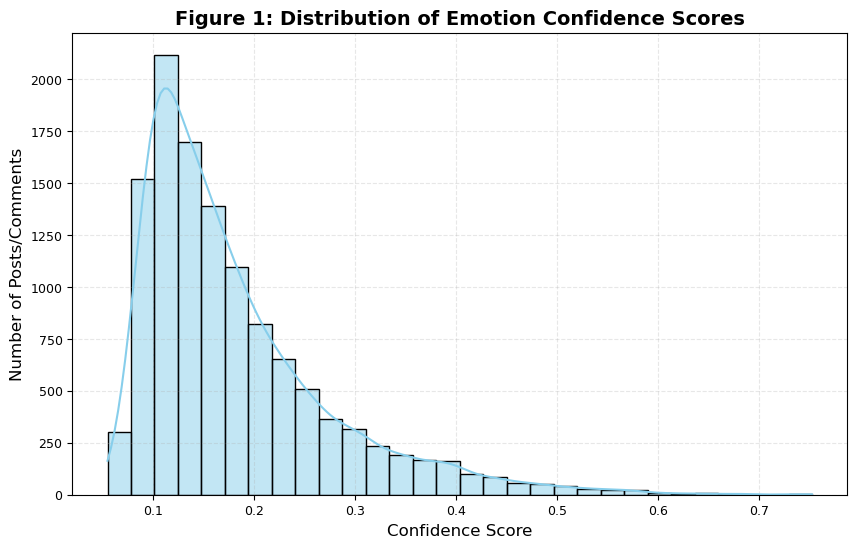


--- Descriptive Statistics of Confidence Scores ---
count    11976.000000
mean         0.180964
std          0.094250
min          0.054786
25%          0.113457
50%          0.153141
75%          0.218680
max          0.752464
Name: emotion_score, dtype: float64


In [6]:
# Plot the distribution of emotion confidence scores
plt.figure(figsize=(10, 6))
sns.histplot(df_duo_ai_sentiment_raw['emotion_score'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Figure 1: Distribution of Emotion Confidence Scores', fontsize=14, fontweight='bold')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Number of Posts/Comments', fontsize=12)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True, linestyle='--', alpha=0.3)

# Save plot to figures folder
os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/Fig1_emotion_confidence_distribution.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Print descriptive statistics
print('\n--- Descriptive Statistics of Confidence Scores ---')
print(df_duo_ai_sentiment_raw['emotion_score'].dropna().describe())

The descriptive statistics reveal an average emotion confidence score of approximately `0.18`, with a median of `0.15`, indicating that most predictions carry relatively low certainty. While some scores reach as high as `0.75`, the distribution is skewed toward lower values — a common pattern in multi-label emotion models like the **GoEmotions pipeline**, which assigns probabilities across 28 distinct emotional categories.

This spread reflects both the model’s design and the **nuanced nature of Reddit discussions**, where sentiment is often ambiguous or mixed. Rather than signaling a flaw in the model, these results highlight the **challenge of classifying subtle emotional cues** in informal, mixed-sentiment text like Reddit comments.

For this project, a **confidence threshold of 0.2** is used to filter emotion predictions — meaning only those with a score above 20% are included in the analysis. This helps focus on clearer emotional signals while still retaining enough data to identify meaningful patterns and trends in public sentiment.

In [7]:
# Apply confidence threshold
confidence_threshold = 0.2
original_rows = len(df_duo_ai_sentiment_raw)
df_duo_ai_sentiment = df_duo_ai_sentiment_raw[df_duo_ai_sentiment_raw['emotion_score'] >= confidence_threshold].copy()
filtered_rows = len(df_duo_ai_sentiment)

print(f'✅ Filtered data: Kept {filtered_rows} out of {original_rows} entries (confidence >= {confidence_threshold})')

# Save filtered data
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'duo_ai_with_sentiment.csv')
df_duo_ai_sentiment.to_csv(output_path, index=False)
print(f"✅ Filtered data saved to '{output_path}'")

✅ Filtered data: Kept 3635 out of 11976 entries (confidence >= 0.2)
✅ Filtered data saved to '../data/processed/duo_ai_with_sentiment.csv'


### 3.3. Weekly Emotion Trend Analysis

Understanding how emotions evolved over time is key to interpreting the public reaction to Duolingo’s AI-first announcement on April 28, 2025. In this section, I analyze emotion trends on a **weekly basis**, focusing on the **top five most frequent emotional responses** before and after the announcement.

By aggregating data week-by-week and visualizing dominant emotions, we can identify:
- How sentiment shifted around the event
- Whether backlash or support emerged gradually or suddenly
- If any emotions spiked after further clarification from the company

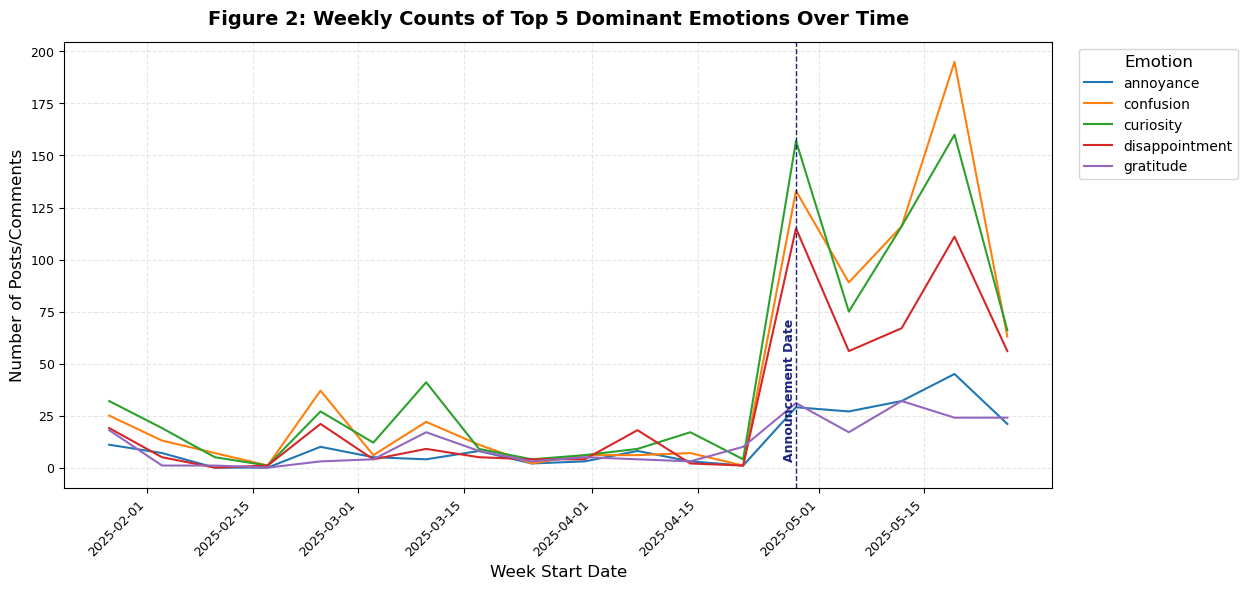

In [8]:
# Define decision date for plotting
decision_date_plot = datetime.strptime('2025-04-28', '%Y-%m-%d').date()

# Add 'created_week' column for weekly aggregation
df_duo_ai_sentiment['created_week'] = df_duo_ai_sentiment['created_at'].dt.to_period('W').dt.start_time

# Identify top 5 most frequent emotions
emotion_frequencies = df_duo_ai_sentiment['emotion_label'].value_counts()
top_5_emotions = emotion_frequencies.head(5).index.tolist()

# Filter and aggregate by week
df_filtered_top_5 = df_duo_ai_sentiment[df_duo_ai_sentiment['emotion_label'].isin(top_5_emotions)].copy()
weekly_top_5_counts = df_filtered_top_5.groupby(['created_week', 'emotion_label']).size().unstack(fill_value=0)

# Plot weekly emotion trends
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_top_5_counts, dashes=False, linewidth=1.5)

plt.title('Figure 2: Weekly Counts of Top 5 Dominant Emotions Over Time', fontsize=14, fontweight='bold', y=1.02)
plt.xlabel('Week Start Date', fontsize=12)
plt.ylabel('Number of Posts/Comments', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True, linestyle='--', alpha=0.3)

# Place legend outside plot area
plt.legend(title='Emotion', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, title_fontsize='12')

# Add vertical line for AI-first announcement date
announcement_color = '#1a237e'
plt.axvline(x=pd.to_datetime(decision_date_plot), color=announcement_color, linestyle='--', lw=1)

# Get current y-limits after lineplot has been drawn
current_ylim = plt.ylim()
plt.text(pd.to_datetime(decision_date_plot), current_ylim[1] * 0.35, 'Announcement Date',
         rotation=90, va='top', ha='right', color=announcement_color, fontsize=9, fontweight='bold')

plt.tight_layout(rect=[0, 0, 0.9, 1])

# Save and display plot
os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/Fig2_weekly_emotion_trends.png', dpi=300, bbox_inches='tight')
plt.show()

**Figure 2** displays weekly trends in dominant emotions expressed in Reddit posts and comments mentioning Duolingo and AI from January to May 2025. The five most frequent emotions in that period were: **annoyance**, **confusion**, **curiosity**, **disappointment**, and **gratitude**.

#### Key Context

* **Feb 11, 2025**: Duolingo announced on social media that its mascot, **Duo** the owl, had **"died."** The campaign quickly went viral, drawing reactions from celebrities (including Dua Lipa), other brands, and millions of users. 
* **Feb 25, 2025**: Duolingo posted a video showing Duo emerging from a coffin, declaring "Legends never die" and **"Duo is back."**
* **Apr 28, 2025**: The company announces its shift to an **"AI-first"** strategy, sparking a strong wave of user reactions.
* **May 23, 2025**: Duolingo **walked back** from its "AI-first" stance. CEO Luis von Ahn stated that AI would be used as a tool to accelerate work, not to eliminate human roles.

#### Emotion Trends Over Time

* **Late February to Early March**:
  * Spikes in **confusion** and **curiosity**, followed by a brief peak in **disappointment** and a rise in **gratitude**, likely reflect reactions to Duolingo’s dramatic "death" and "resurrection" campaign.<br><br>
  
* **Late April to Early May**:

  * Following the AI-first announcement, there is a sharp rise in **curiosity**, **confusion**, and **disappointment**.
  * These emotions far surpass earlier highs, indicating broader concern.<br><br>

* **Late May**:

  * In the week of May 19, **confusion**, **curiosity**, and **disappointment** spike again.
  * This coincides with the **CEO's clarification** that Duolingo would not use AI to replace employees, marking a shift from the company’s earlier tone.

### 3.4. Contrasting Sentiments Over Time

Our initial exploration provided a valuable overview of the dominant emotions (Figure 2). Now let's compare two sets of contrasting sentiments, **Approval vs. Disapproval** and **Admiration vs. Disappointment**, to visualize how they evolved over time, particularly before and after critical events like the AI-first announcement on April 28, 2025.

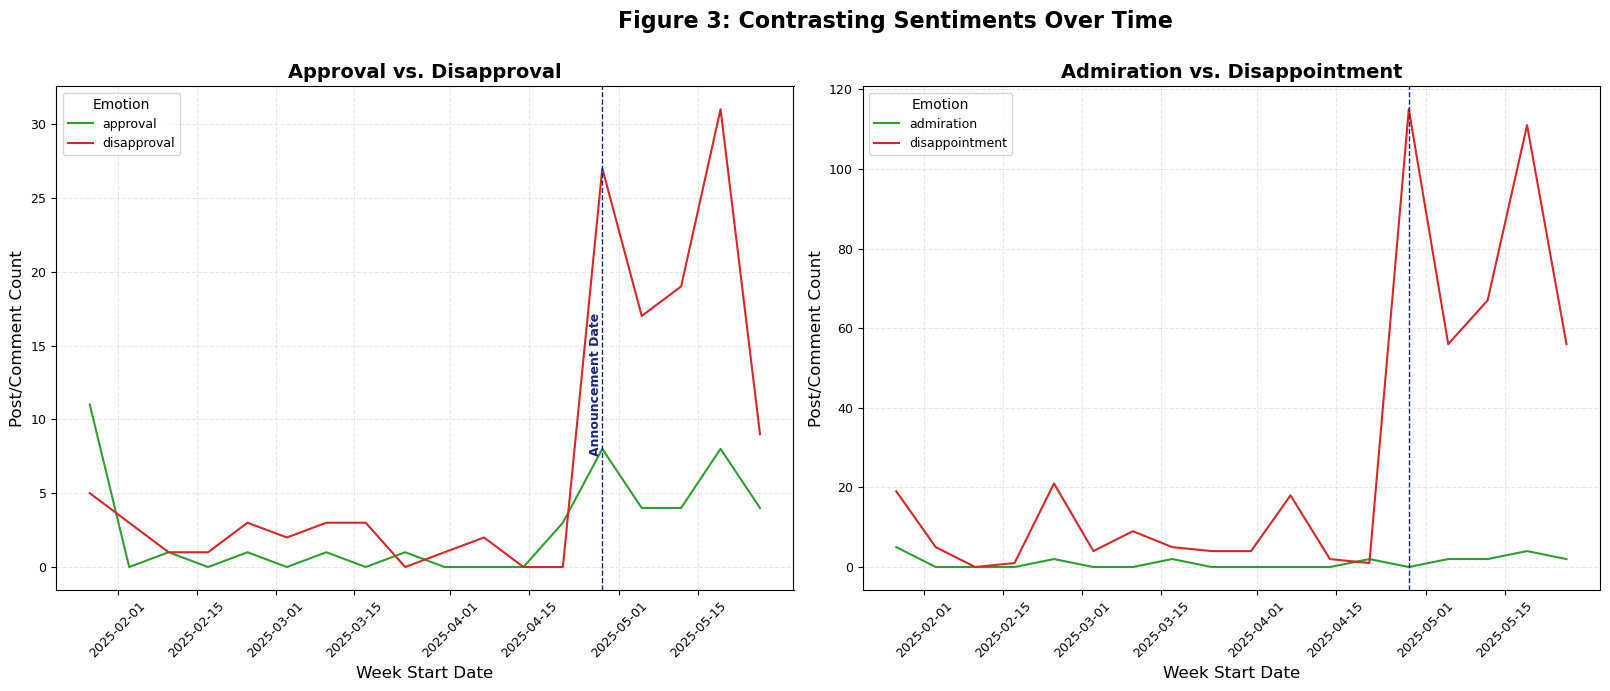

In [9]:
# Define decision date for plotting
decision_date_plot = datetime.strptime('2025-04-28', '%Y-%m-%d').date()

# Define emotion pairs for visualization
opposing_emotion_pairs = {
    'Approval vs. Disapproval': ['approval', 'disapproval'],
    'Admiration vs. Disappointment': ['admiration', 'disappointment']
}

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
axes = axes.flatten()

# Positive and negative emotion lists for color mapping
positive_emotions_list = ['approval', 'admiration']
negative_emotions_list = ['disapproval', 'disappointment']

# Iterate through emotion pairs and plot
for i, (title, emotions) in enumerate(opposing_emotion_pairs.items()):
    ax = axes[i]

    # Filter for emotions present in the data
    emotions_present = [emo for emo in emotions if emo in df_duo_ai_sentiment['emotion_label'].unique()]

    if not emotions_present:
        ax.set_title(f'{title} (No Data)', fontsize=14, fontweight='bold')
        ax.text(0.5, 0.5, 'No data for these emotions', transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center',
                color='red', fontsize=12)
        ax.tick_params(labelbottom=True, rotation=45)
        continue

    # Aggregate weekly counts
    weekly_counts = df_duo_ai_sentiment.groupby(['created_week', 'emotion_label']).size().unstack(fill_value=0)
    data_to_plot = weekly_counts[[emo for emo in emotions_present if emo in weekly_counts.columns]]

    # Build custom palette
    palette = {}
    for emo in data_to_plot.columns:
        if emo in positive_emotions_list:
            palette[emo] = '#2ca02c'  # Green
        elif emo in negative_emotions_list:
            palette[emo] = '#d62728'  # Red

    # Plot line chart with custom colors
    sns.lineplot(data=data_to_plot, linewidth=1.5, ax=ax, palette=palette, dashes=False)

    # Configure subplot
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Week Start Date', fontsize=12)
    ax.set_ylabel('Post/Comment Count', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(title='Emotion', loc='upper left', fontsize=9, title_fontsize='10')

    # Add vertical line for announcement date
    announcement_color = '#1a237e'
    ax.axvline(x=pd.to_datetime(decision_date_plot), color=announcement_color, linestyle='--', lw=1)

    # Add text only on first subplot
    if i == 0:
        ax.text(pd.to_datetime(decision_date_plot), ax.get_ylim()[1] * 0.53, 'Announcement Date',
                rotation=90, va='top', ha='right', color=announcement_color, fontsize=9, fontweight='bold')

# Final layout adjustments
fig.suptitle('Figure 3: Contrasting Sentiments Over Time', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.98])

# Save to figures folder
os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/Fig3_contrasting_sentiments_trend.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

#### Key Insights

- Small spikes in **disapproval** and **disappointment** align with the Duo "death" and "resurrection" campaign.
- A **sharp rise in disapproval and disappointment** follows the AI-first announcement on April 28, 2025, and apparently the CEO's clarification on May 23 fails to reverse the trend. Concurrently, smaller peaks of **approval** were also observed during this period, indicating mixed user reactions.

---

## 4. Word Cloud: What Reddit Users Talked About Most

This section focuses on preparing and generating a **word cloud** to visually highlight the most common themes discussed by Reddit users after Duolingo’s AI-first announcement. The process involves several key steps, combining **Natural Language Processing (NLP)** tools and visual customization:

* **NLTK Resource Setup:**
  The script downloads essential NLTK resources (`stopwords`, `wordnet`, and `punkt`) used for basic text preprocessing and filtering.

* **SpaCy Model Loading:**
  The lightweight English model `en_core_web_sm` is loaded with an increased `max_length` to handle large text inputs.

* **Data Loading and Filtering:**
  Reddit posts and comments are loaded from the preprocessed CSV file. The data is then filtered to include only content **from April 28, 2025 onwards**, ensuring the word cloud reflects the conversation that unfolded after the AI announcement.

* **Word Cloud Mask Preparation:**
  A Duo-shaped image is used as a **mask** to shape the word cloud. The image is resized, binarized, and inverted to match the expected input format for the word cloud mask.

* **Custom Stopwords List:**
  In addition to the standard English stopwords, a list of **Duolingo-specific** or **common-but-uninformative words** (e.g., "app", "user", "language", "people") is added to prevent them from dominating the word cloud.

* **Text Preprocessing with SpaCy:**
  The filtered text is processed with SpaCy to extract only **nouns** and **adjectives**, which are typically the most informative for topic analysis. Lemmatization is also applied.

* **Word Cloud Generation and Styling:**
  A WordCloud object is created with the custom stopwords and Duo-shaped mask. A special color function applies various shades of green, aligning the visual output with Duolingo's brand.

* **Output and Visualization:**
  The resulting word cloud is displayed and saved.

This visual provides an engaging overview of the **most salient themes** in user discussions, complementing the sentiment timeline shown earlier.

Checking NLTK resources...
NLTK stopwords already available.
Downloaded NLTK WordNet.
NLTK Punkt tokenizer already available.
✅ NLTK resources checked.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ SpaCy model loaded and max_length adjusted.
✅ Successfully loaded '../data/processed/duo_ai_with_sentiment.csv'
Analyzing 2767 posts/comments from 2025-04-28 onward.
✅ Loaded 'duo_mask.png' for masking.
✅ Mask image prepared.

Generating word cloud with SpaCy...


C:\Users\mathe\AppData\Local\Temp\ipykernel_8168\1327079584.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greens')


✅ Word cloud saved to '../figures/Fig4_wordcloud_spacy.png'.


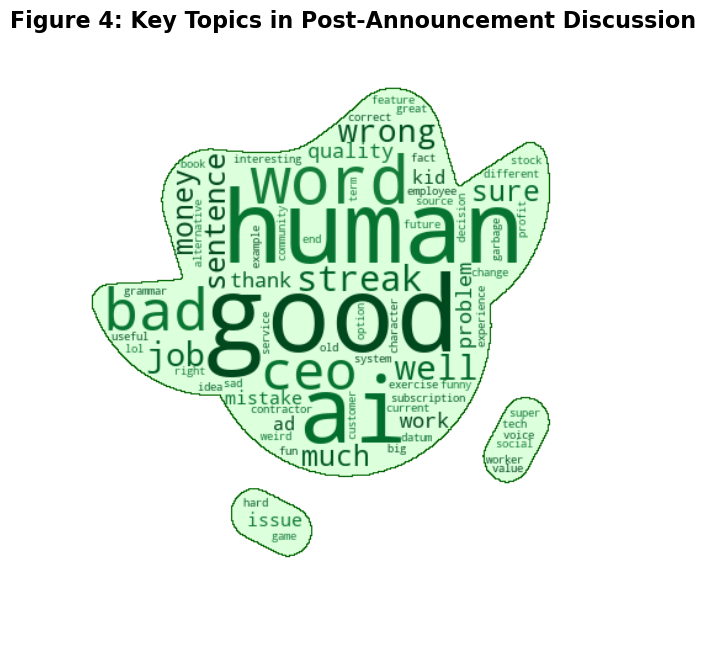

In [13]:
# --- NLTK and SpaCy Setup ---
# Suppress NLTK warnings if already downloaded
warnings.filterwarnings('ignore', category=UserWarning, module='nltk')

print('Checking NLTK resources...')
try:
    nltk.data.find('corpora/stopwords')
    print('NLTK stopwords already available.')
except LookupError:
    print('Downloading NLTK stopwords...')
    nltk.download('stopwords')
    print('Downloaded NLTK stopwords.')

try:
    nltk.data.find('corpora/wordnet')
    print('NLTK WordNet already available.')
except LookupError:
    print('Downloading NLTK WordNet...')
    nltk.download('wordnet')
    print('Downloaded NLTK WordNet.')

try:
    nltk.data.find('tokenizers/punkt')
    print('NLTK Punkt tokenizer already available.')
except LookupError:
    print('Downloading NLTK Punkt tokenizer...')
    nltk.download('punkt')
    print('Downloaded NLTK Punkt tokenizer.')

print("✅ NLTK resources checked.")

# Load SpaCy model
try:
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2500000
    print("✅ SpaCy model loaded and max_length adjusted.")
except OSError:
    print("❌ SpaCy model 'en_core_web_sm' not found. Please run 'python -m spacy download en_core_web_sm'")
    nlp = None


# Data Loading
input_sentiment_filename = '../data/processed/duo_ai_with_sentiment.csv'

try:
    df_duo_ai_sentiment = pd.read_csv(input_sentiment_filename)
    df_duo_ai_sentiment['created_at'] = pd.to_datetime(df_duo_ai_sentiment['created_at'])
    print(f"✅ Successfully loaded '{input_sentiment_filename}'")
except FileNotFoundError:
    print(f"❌ Error: File '{input_sentiment_filename}' not found.")
    df_duo_ai_sentiment = pd.DataFrame()
except Exception as e:
    print(f"❌ Unexpected error loading data: {e}")
    df_duo_ai_sentiment = pd.DataFrame()

if df_duo_ai_sentiment.empty:
    print("⚠️ Cannot proceed with word cloud generation as DataFrame is empty.")
else:
    # Filter data: from announcement date onwards
    announcement_date = datetime.strptime('2025-04-28', '%Y-%m-%d').date()
    df_duo_ai_sentiment['created_date'] = df_duo_ai_sentiment['created_at'].dt.date
    df_post_announcement = df_duo_ai_sentiment[df_duo_ai_sentiment['created_date'] >= announcement_date].copy()

    if df_post_announcement.empty:
        print(f"No data from {announcement_date} onward for word cloud generation.")
    else:
        text_data = ' '.join(df_post_announcement['cleaned_text'].dropna().astype(str).tolist())
        print(f"Analyzing {len(df_post_announcement)} posts/comments from {announcement_date} onward.")

        # Word cloud mask preparation
        try:
            original_image = Image.open('../data/raw/duo_mask.png')
            print("✅ Loaded 'duo_mask.png' for masking.")
        except FileNotFoundError:
            print("⚠️ Warning: 'duo_mask.png' not found. Creating placeholder.")
            original_image = Image.new('L', (200, 200), 0)
            draw = ImageDraw.Draw(original_image)
            draw.ellipse((50, 20, 150, 100), fill=255)
            draw.ellipse((30, 70, 90, 130), fill=255)
            draw.ellipse((110, 70, 170, 130), fill=255)
            draw.ellipse((70, 150, 100, 180), fill=255)
            draw.ellipse((120, 140, 150, 170), fill=255)
            original_image = original_image.filter(ImageFilter.GaussianBlur(radius=5))
            original_image = original_image.point(lambda x: 255 if x > 60 else 0)

        base_image = original_image.convert('L')
        target_size = (500, 500)
        resized_image = base_image.resize(target_size, Image.Resampling.LANCZOS)
        threshold = 128
        mask_for_coloring = resized_image.point(lambda p: 255 if p > threshold else 0)
        mask_image_array = np.array(ImageOps.invert(mask_for_coloring))
        print("✅ Mask image prepared.")

        # Custom stopwords List
        custom_stopwords = set(stopwords.words('english'))
        custom_stopwords.update([
            'duolingo', 'duo', 'app', 'language', 'learning', 'new', 'reddit',
            'user', 'users', 'whole', 'long', 'time', 'way', 'one', 'many',
            'little', 'lot', 'couple', 'low', 'high', 'thing', 'people',
            'class', 'course', 'courses', 'lesson', 'lessons', 'story', 'stories',
            'practice', 'practices', 'student', 'students', 'teacher', 'teachers',
            'free', 'content', 'tool', 'world', 'question', 'comment', 'part',
            'point', 'reason', 'fuck', 'shit', 'company', 'product', 'stuff',
            'education', 'year', 'day', 'today', 'month', 'week', 'video', 'german',
            'spanish', 'french', 'italian', 'english', 'japanese', 'care',
            'translation', 'school', 'number', 'sub', 'able', 'real', 'first', 'last',
            'post', 'life', 'bit', 'speaker', 'sense', 'easy', 'actual', 'answer',
            'level', 'place', 'person', 'native', 'guy'
        ])
                
        # Custom color function for darker greens
        def green_color_func(word, font_size, position, orientation, random_state=20, **kwargs):
            cmap = plt.cm.get_cmap('Greens')
            # Bias towards darker greens for better readability
            random_value = random_state.uniform(0.8, 1.0)  # Use darker greens
            rgb = cmap(random_value)[:3]
            return mcolors.rgb2hex(rgb)

        # Word cloud generation (SpaCy nouns & adjectives)
        if nlp is not None:
            print('\nGenerating word cloud with SpaCy...')

            def preprocess_spacy(text):
                doc = nlp(text.lower())
                filtered_tokens = [
                    token.lemma_ for token in doc
                    if token.pos_ in ['NOUN', 'ADJ'] and token.is_alpha and token.text not in custom_stopwords
                ]
                return " ".join(filtered_tokens)

            processed_text_spacy = preprocess_spacy(text_data)

            wordcloud_spacy = WordCloud(
                background_color='rgba(255, 255, 255, 0)',  # Transparent background
                mode='RGBA',
                width=target_size[0],
                height=target_size[1],
                max_words=500,
                mask=mask_image_array,
                stopwords=custom_stopwords,
                color_func=green_color_func,
                collocations=False,
                min_font_size=8
            ).generate(processed_text_spacy)

            # --- Image Compositing for Background Colors and Contour ---
            # Create a solid white background image
            final_image = Image.new('RGB', wordcloud_spacy.to_image().size, 'white')

            # Create a light green background for owl shape
            light_green_background = Image.new('RGB', wordcloud_spacy.to_image().size, (220, 255, 220))

            # Paste only where mask_for_coloring is white
            final_image.paste(light_green_background, (0, 0), mask=mask_for_coloring.convert('L'))

            # Overlay word cloud using its alpha channel as mask
            wc_image = wordcloud_spacy.to_image()
            final_image.paste(wc_image, (0, 0), mask=wc_image.split()[3])  # Use alpha channel

            # Draw contour around owl shape
            edge_mask = mask_for_coloring.point(lambda p: 255 if p == 255 else 0)
            edge_mask = edge_mask.filter(ImageFilter.FIND_EDGES)

            # Create transparent contour layer
            contour_img = Image.new('RGBA', final_image.size, (0, 0, 0, 0))
            draw_contour = ImageDraw.Draw(contour_img)

            edges_np = np.array(edge_mask)
            coords = np.argwhere(edges_np == 255)

            for y, x in coords:
                draw_contour.rectangle([x, y, x + 0.8, y + 0.8], fill=(0, 100, 0, 255))

            final_image = final_image.convert('RGBA')
            final_image.paste(contour_img, (0, 0), mask=contour_img)

            # Plot word cloud
            plt.figure(figsize=(12, 8))
            plt.imshow(final_image, interpolation='bilinear')
            plt.title('Figure 4: Key Topics in Post-Announcement Discussion', fontsize=16, fontweight='bold')
            plt.axis('off')

            # Save to figures folder
            os.makedirs('../figures', exist_ok=True)
            output_plot_path = '../figures/Fig4_wordcloud_spacy.png'
            plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
            print(f"✅ Word cloud saved to '{output_plot_path}'.")

            # Show plot
            plt.show()
        else:
            print('⚠️ Skipping SpaCy word cloud: Model failed to load.')   

#### Key Insights
* Frequent use of *"human"* and *"AI"* suggests users are focused on the tension between automation and human involvement.
* Mentions of *"job,"* *"employee,"* and *"contractor"* indicate concern over potential job impacts and workforce changes.
* *"Sentence,"* *"grammar,"* and *"word"* likely reflect everyday learning experiences rather than direct commentary on the AI strategy.
* Words such as *"subscription,"* *"money,"* and *"profit"* suggest that users may have perceived the AI-first strategy as having significant financial motivations.

## 5. Popular Reactions: Top Comments on Core Themes

The word cloud is a powerful tool for visualizing the most frequently discussed topics. However, frequency alone doesn’t reveal the **tone** or **context** in which these words were used. In this section, I’ll focus on some of the **most common keywords** from the word cloud and zoom in on comments and posts that received the **highest engagement**.

To enhance readability, I’ve filtered for entries with a maximum of **95 characters**, ensuring concise and impactful content. Additionally, I’ve highlighted those posts and comments that received the **highest Reddit score** after Duolingo’s AI-first announcement (April 28, 2025). By sorting these by **Reddit score** — a metric reflecting upvotes minus downvotes — we gain deeper insights into what users **actually meant** when using these words and which thoughts resonated most strongly with the community post-announcement.

This approach provides a clearer picture of how users felt about Duolingo’s AI shift, going beyond mere word frequency to uncover **real sentiment** and **engagement trends**.

In [14]:
# Configuration
target_keywords = ['good', 'human', 'ai', 'job', 'ceo', 'subscription']
num_results_per_keyword = 5
max_text_length = 95
decision_date_filter = datetime.strptime('2025-04-28', '%Y-%m-%d').date()

# Filter for post-decision comments/posts
df_duo_ai_sentiment['created_date_only'] = df_duo_ai_sentiment['created_at'].dt.date
df_duo_ai_sentiment = df_duo_ai_sentiment[df_duo_ai_sentiment['created_date_only'] >= decision_date_filter].copy()
print(f"✅ Filtered data: {len(df_duo_ai_sentiment)} entries from {decision_date_filter} onward.")

# Prepare original text column
df_duo_ai_sentiment['original_text'] = df_duo_ai_sentiment['title'].fillna('') + ' ' + df_duo_ai_sentiment['text'].fillna('')

# Keep only the first line of each comment/post
df_duo_ai_sentiment['original_text'] = df_duo_ai_sentiment['original_text'].str.split('\n').str[0]

# Filter by max text length
df_duo_ai_sentiment = df_duo_ai_sentiment[df_duo_ai_sentiment['original_text'].str.len() <= max_text_length].copy()
print(f"✅ Kept texts ≤ {max_text_length} characters.")

# Ensure score is numeric
if 'score' in df_duo_ai_sentiment.columns:
    df_duo_ai_sentiment['score'] = pd.to_numeric(df_duo_ai_sentiment['score'], errors='coerce')
    df_duo_ai_sentiment.dropna(subset=['score'], inplace=True)
else:
    print("❌ Error: 'score' column missing. Cannot sort by score.")
    df_duo_ai_sentiment = pd.DataFrame()

# Retrieve top posts for each keyword
print('\nTop Posts/Comments by Keyword and Score (Post-Decision)')

id_col_width = 20
score_col_width = 10
text_col_width = max_text_length

for keyword in target_keywords:
    print(f"\nResults for keyword: '{keyword}'")

    keyword_pattern = r'\b' + re.escape(keyword) + r'\b'
    df_keyword_filtered = df_duo_ai_sentiment[
        df_duo_ai_sentiment['original_text'].str.contains(keyword_pattern, regex=True, case=False, na=False)
    ].copy()

    if not df_keyword_filtered.empty:
        # Sort by Reddit score
        df_sorted_by_score = df_keyword_filtered.sort_values(by='score', ascending=False).head(num_results_per_keyword)

        # Print header
        print(f"{'Post/Comment ID':<{id_col_width}} | {'Score':<{score_col_width}} | {'Original Text':<{text_col_width}}")
        print("-" * (id_col_width + score_col_width + text_col_width + 6))

        for _, row in df_sorted_by_score.iterrows():
            post_id = str(row.get('id', 'N/A'))
            score = str(int(row.get('score', 'N/A')))
            original_text = str(row.get('original_text', 'N/A'))

            print(f"{post_id:<{id_col_width}} | {score:<{score_col_width}} | {original_text:<{text_col_width}}")

        print("\n" + "=" * (id_col_width + score_col_width + text_col_width + 6))
    else:
        print(f"No posts found for keyword '{keyword}'.")

✅ Filtered data: 2767 entries from 2025-04-28 onward.
✅ Kept texts ≤ 95 characters.

Top Posts/Comments by Keyword and Score (Post-Decision)

Results for keyword: 'good'
Post/Comment ID      | Score      | Original Text                                                                                  
-----------------------------------------------------------------------------------------------------------------------------------
mtc5fxe              | 232        |  Duolingo wasn’t even a good way to learn languages. Good riddance.                            
mup8udp              | 75         |  Why is a falsely imposed balance a good thing?                                                
mu52wmg              | 18         |  CEO is actually a good fit for AI replacement.  Odd you don’t hear much about that.           
mq7ohgm              | 16         |  Calm down, its a good tool for beginner-intermediate language learning                        
mu24wlj              | 16         |  G

#### Key Insights

- **Polarized opinions on the app**
  * Some users expressed disappointment with comments like *"Duolingo wasn’t even a good way to learn languages."*
  * Others defended the app, calling it *"a good tool for beginner–intermediate language learning."*<br><br>

- **Nuanced use of the word "good"**
  * While "good" appeared prominently in the word cloud, in top comments it was often used with **ironic or negative connotations**.
  * Examples include:
    * *"Good riddance."*
    * *"CEO is actually a good fit for AI replacement."*
  * This highlights the importance of **qualitative analysis and linguistic context** when interpreting word cloud data.<br><br>

- **Backlash centered around job cuts and contractor replacement**:  
  - High-scoring comments repeatedly raised concerns about **workforce impact**, particularly around the removal of human contractors.
  - Many posts associate AI with a perceived **decline in human presence** at Duolingo.<br><br>

- **Users felt their voices weren't heard**:  
  - The tone of top comments suggests frustration with Duolingo’s messaging and decision-making process.
  - Example: *"Feels like this CEO doesn’t understand human learning."*<br><br>

- **Impact on user engagement and retention**:
    * Highly upvoted comments related to "subscription" reveal direct financial consequences, with users actively **canceling paid memberships**.
    * These comments underscore a significant risk of user churn, as some explicitly state they have deleted the app and are looking for alternatives.

---

## 6. Conclusion

This journey through Duolingo's Reddit discussions offered a compelling demonstration of how **Natural Language Processing (NLP)** can be used to analyze public sentiment during pivotal corporate moments. The project not only answered the initial research questions but also revealed a nuanced landscape of emotions and user concerns.

### What the Data Revealed

* **Before and after the AI-first announcement**, the most prominent emotions were **confusion** and **curiosity**.
  During the viral "Duo is dead" and resurrection campaign in February, there was also a notable spike in **disappointment**, quickly followed by a rise in **gratitude** — a reaction in line with the campaign’s playful narrative arc.

* The **AI-first announcement** on **April 28, 2025**, triggered a sharp surge in **curiosity**, **confusion**, and especially **disappointment**.
  These emotions **far surpassed previous peaks**, signaling a strong, collective concern from the community.

* The **CEO's clarification** on **May 23, 2025** was a positive gesture, but the emotional trends suggest it did not immediately change the narrative.
  New spikes in **disappointment** and **annoyance** point to a **lingering unease** despite the more measured messaging.


### What the Community Was Saying

In addition to the emotional analysis, the word cloud and top-comment review exposed strong thematic patterns:

* Frequent mentions of **"human,"** **"AI,"** and **"job"** reflected deep concerns about the **impact of automation on human roles and employment**.

* Highly upvoted comments such as:<br>
  *"Is Duolingo the face of an AI jobs crisis?"*<br>
  *"Every time you replace a contractor with AI, you break a piece of my heart too"*<br>
  illustrate how the announcement became a **lightning rod** for broader frustrations about AI and job displacement.

* Mentions of **"subscription"** highlighted that changes related to AI directly impacted user commitment, leading some to **cancel paid memberships and abandon app use**.

### Limitations

While this project offers useful perspectives on public sentiment, it's important to acknowledge certain limitations:

* **Data Source Scope:** The analysis was solely based on Reddit data, which may not fully represent the sentiment across all social media platforms or the general public. Different platforms (e.g., Twitter, TikTok) might exhibit varied user demographics and discussion patterns.
* **Sentiment Model Nuances:** The GoEmotions model, while robust, categorizes emotions into 28 specific labels. Human emotion is complex, and some nuanced sentiments might not be perfectly captured or may overlap between categories. Additionally, reliance on confidence thresholds could exclude some relevant, albeit lower-confidence, expressions.
* **Qualitative Depth:** Although a word cloud and top comments were reviewed, a more extensive qualitative analysis could provide deeper contextual understanding.

### Final Thoughts

This project highlights the **essential role of data science** in understanding public perception at scale. As a big fan of Duolingo's innovative spirit and their ability to reinvent themselves time and again, I am confident in their capacity to navigate this challenging moment. Their history of successful strategies shows they possess the skills needed to address these concerns and continue building a vibrant learning community. For me, this was also a powerful example of how NLP can uncover **valuable insights** to support companies facing major strategic decisions.